In [1]:
import kagglehub
import os 
import shutil 
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm 
import cv2 
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO

In [ ]:
# kagglehub.login()

# Dataset Loading

In [ ]:
path = kagglehub.dataset_download(handle="tkm22092/indian-number-plate-images")

source_path = path 
current_directory = os.getcwd() 
dataset_folder_name = os.path.basename(source_path)
destination_path = os.path.join(current_directory, dataset_folder_name)

if os.path.exists(destination_path):
    print(f"The folder {dataset_folder_name} already exists at {destination_path}")
else:
    try:
        shutil.move(source_path, destination_path)
        print("Dataset successfully moved")
    except:
        print("Error in copying")

In [ ]:
path = kagglehub.dataset_download(handle = "aslanahmedov/number-plate-detection")

source_path = path 
current_directory = os.getcwd() 
dataset_folder_name = os.path.basename(source_path)
destination_path = os.path.join(current_directory, dataset_folder_name)

if os.path.exists(destination_path):
    print(f"The folder {dataset_folder_name} already exists at {destination_path}")
else:
    try:
        shutil.move(source_path, destination_path)
        print("Dataset successfully moved")
    except:
        print("Error in copying")

# Conversion & Folder Creation

In [ ]:
SOURCE_DIR = "30/images"
DEST_DIR = "data"

IMAGES_OUT = os.path.join(DEST_DIR, "images")
LABELS_OUT = os.path.join(DEST_DIR, "labels")

os.makedirs(IMAGES_OUT, exist_ok=True)
os.makedirs(LABELS_OUT, exist_ok=True)

In [ ]:
def voc_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = ((xmin + xmax) / 2) / img_w
    y_center = ((ymin + ymax) / 2) / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return x_center, y_center, width, height

In [ ]:
CLASS_MAPPING = {
    "number_plate": 0,
    "num_plate" : 0
}

for file in tqdm(os.listdir(SOURCE_DIR)):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(SOURCE_DIR, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    image_path = os.path.join(SOURCE_DIR, filename)

    # Copy image
    if os.path.exists(image_path):
        shutil.copy(image_path, IMAGES_OUT)

    # Image size
    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    yolo_lines = []

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        class_id = CLASS_MAPPING[class_name]

        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        x_c, y_c, w, h = voc_to_yolo(
            xmin, ymin, xmax, ymax, img_w, img_h
        )

        yolo_lines.append(
            f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"
        )

    # Write label file
    label_filename = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(LABELS_OUT, label_filename)

    with open(label_path, "w") as f:
        f.write("\n".join(yolo_lines))

In [ ]:
img_path = r"data\images\N1.jpeg"
label_path = r"data\labels\N1.txt"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_h, img_w, c = img.shape 

with open(label_path, "r") as f:
    lines = f.readlines()

plt.figure(figsize=(10,6))

for line in lines:
    class_id, x_c, y_c, w, h = map(float, line.split())

    x_centre = x_c*img_w 
    y_centre = y_c*img_h 
    box_w = int(w*img_w) 
    box_h = int(h*img_h) 

    xmin = int(x_centre - box_w/2)
    ymin = int(y_centre - box_h/2)
    xmax = int(xmin + box_w)
    ymax = int(ymin + box_h)

    rect = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 4)

plt.imshow(rect)

In [ ]:
SRC_IMAGES = "2/images"
SRC_LABELS = "2/yolo_labels"

DST_IMAGES = "data/images"
DST_LABELS = "data/labels"

os.makedirs(DST_IMAGES, exist_ok=True)
os.makedirs(DST_LABELS, exist_ok=True)

image_map = {}

for root, _, files in os.walk(SRC_IMAGES):
    for file in files:
        name, ext = os.path.splitext(file)
        if ext.lower() in [".jpg", ".jpeg", ".png"]:
            image_map[name] = os.path.join(root, file)

copied = 0
skipped = 0

for label_file in tqdm(os.listdir(SRC_LABELS)):
    if not label_file.endswith(".txt"):
        continue

    base_name = os.path.splitext(label_file)[0]

    if base_name not in image_map:
        skipped += 1
        continue

    # Copy image
    shutil.copy(
        image_map[base_name],
        os.path.join(DST_IMAGES, os.path.basename(image_map[base_name]))
    )

    # Copy label
    shutil.copy(
        os.path.join(SRC_LABELS, label_file),
        os.path.join(DST_LABELS, label_file)
    )

    copied += 1


In [ ]:
print(f"Total images are {len(os.listdir('data/images'))} \nTotal Labels are {len(os.listdir('data/labels'))}")

In [ ]:
DATA_IMAGES = "data/images"
DATA_LABELS = "data/labels"
DATASET_DIR = "dataset"

SPLITS = {
    "train": 0.7,
    "val": 0.2,
    "test": 0.1
}

IMG_EXTS = [".jpg", ".jpeg", ".png"]

for split in SPLITS:
    os.makedirs(os.path.join(DATASET_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, split, "labels"), exist_ok=True)

images = {
    os.path.splitext(f)[0]: f
    for f in os.listdir(DATA_IMAGES)
    if os.path.splitext(f)[1].lower() in IMG_EXTS
}

labels = {
    os.path.splitext(f)[0]: f
    for f in os.listdir(DATA_LABELS)
    if f.endswith(".txt")
}

pairs = sorted(list(images.keys() & labels.keys()))
print(f"Total valid pairs: {len(pairs)}")

random.seed(42)   # reproducible split
random.shuffle(pairs)

total = len(pairs)

train_end = int(total * SPLITS["train"])
val_end = train_end + int(total * SPLITS["val"])

train_ids = pairs[:train_end]
val_ids = pairs[train_end:val_end]
test_ids = pairs[val_end:]

def copy_split(ids, split_name):
    for name in ids:
        shutil.copy(
            os.path.join(DATA_IMAGES, images[name]),
            os.path.join(DATASET_DIR, split_name, "images", images[name])
        )
        shutil.copy(
            os.path.join(DATA_LABELS, labels[name]),
            os.path.join(DATASET_DIR, split_name, "labels", labels[name])
        )

In [ ]:
copy_split(train_ids, "train")
copy_split(val_ids, "val")
copy_split(test_ids, "test")

In [ ]:
for split in ["train", "val", "test"]:
    n_img = len(os.listdir(os.path.join(DATASET_DIR, split, "images")))
    n_lbl = len(os.listdir(os.path.join(DATASET_DIR, split, "labels")))
    print(f"{split}: {n_img} images | {n_lbl} labels")


# Model Training

In [ ]:
model = YOLO(model="yolo11s.pt", task="detect")

In [ ]:
results = model.train(data="dataset.yml",
            epochs=30,
            batch=-1,
            imgsz=640, device=0,
            perspective = 0.001, bgr=0.5, mosaic=0.3
            )

In [ ]:
img = cv2.imread(r"runs\detect\train2\results.png")
plt.imshow(img)

# Model Testing

class_id is  7.0


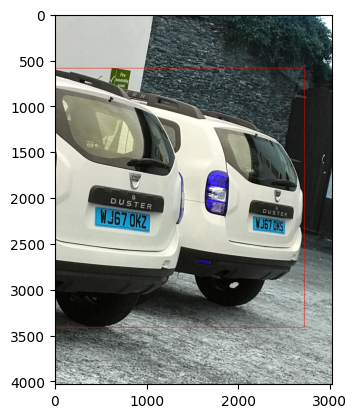

In [17]:
img = cv2.imread(r"2np.jpg")
model = YOLO(model = r"C:\Projects\Road-Runner\weights\yolo11s.pt")

results = model.predict(img, device = 0, verbose=False)
n_det = len(results[0].boxes.cls)
i = results[0]

for index in range(n_det):
    boxes_xyxy = i.boxes.xyxy
    x1,y1,x2,y2 = map(int, boxes_xyxy.detach().cpu().numpy()[index])
    class_id = i.boxes.cls[index].cpu().numpy().item()
    confidence = i.boxes.conf[index].cpu().numpy().item()
    print("class_id is ",class_id)
    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)
plt.imshow(img)

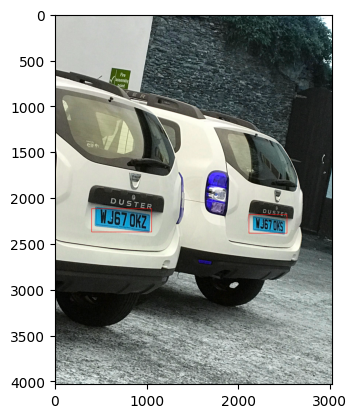

In [2]:
img = cv2.imread(r"2np.jpg")
model = YOLO(model = r"C:\Projects\Road-Runner\weights\yolov11s_np.pt")

results = model.predict(img, device = 0, verbose=False)
n_det = len(results[0].boxes.cls)
i = results[0]

for index in range(n_det):
    boxes_xyxy = i.boxes.xyxy
    x1,y1,x2,y2 = map(int, boxes_xyxy.detach().cpu().numpy()[index])
    class_id = i.boxes.cls[index].cpu().numpy().item()
    confidence = i.boxes.conf[index].cpu().numpy().item()
    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)
plt.imshow(img)

In [13]:
img = cv2.imread(r"black.jpg")
model = YOLO(model = r"C:\Projects\Road-Runner\weights\yolov11s_np.pt")

results = model.predict(img, device = 0, verbose=False)
results[0].boxes.data.cpu().numpy()
#n_det = len(results[0].boxes.cls)

array([], shape=(0, 6), dtype=float32)

In [16]:
len(results[0].boxes) 

0